In [16]:

# 添加了人类节点


In [17]:
from typing import Literal,Annotated, TypedDict, Union
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

from langchain_core.agents import AgentAction, AgentFinish
import operator

from langgraph.graph import END, START,StateGraph
from langgraph.prebuilt import ToolNode , tools_condition
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from langchain_core.pydantic_v1 import BaseModel
from tools_helper import *
from langchain.agents import create_react_agent 

In [18]:

tool=search


In [19]:
# 工具绑定
tools= [search,RequestAssistance]
tool_executor = ToolExecutor(tools)
prompt = react_chat_prompt() # 创建聊天的模板
model_with_tools   = create_react_agent(model, tools, prompt)


In [20]:
def chatbot(state):
    agent_outcome = model_with_tools.invoke(state)
    ask_human=False
    print("agent_outcome:",agent_outcome)
    if "RequestAssistance" in   agent_outcome.log:
        ask_human=True
    return {"agent_outcome": agent_outcome ,"ask_human":ask_human}

In [21]:
# 工具返回信息
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response
    )

In [22]:
# 创建一个状态
class AgentState(TypedDict):
    ask_human: bool # 是否需要人工回答
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [23]:
# 人类节点
def human_node(state: AgentState):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False,
    }

In [24]:
# 运行工具节点
def execute_tools(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    tool_name = last_message.tool
    tool_input = last_message.tool_input
    action = ToolInvocation(
        tool=tool_name,
        tool_input= tool_input
    )
    response = tool_executor.invoke(action)
    return {"intermediate_steps": [(state["agent_outcome"], response)]}


In [25]:
graph = StateGraph(AgentState)
# 增加一个chatbot节点，具有工具调用功能
graph.add_node("chatbot", chatbot)
# 工具节点
graph.add_node("tools", execute_tools)
# 人类节点
graph.add_node("human", human_node)
graph.add_edge("human", "chatbot")
#增加一条边，从开始到chatbot，
graph.set_entry_point("chatbot")    
# 增加一条边，从工具回到chatbot，
graph.add_edge("tools", "chatbot")

In [26]:
# # 从chatbot 发出一条条件边，根据情况到达工具节点或结束
# def router(state):
#     messages = [state["agent_outcome"]]
#     last_message = messages[-1]

#     if "Action"  in last_message.log:
#         return "tools"
#     else:
#         return END
# graph.add_conditional_edges("chatbot", router)

In [27]:
# 添加一个条件边
def select_next_node(state: AgentState):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    if 'Final Answer' in  state['agent_outcome'].log:
        return "__end__"
    return "tools"


graph.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [28]:
graph_runner = graph.compile()

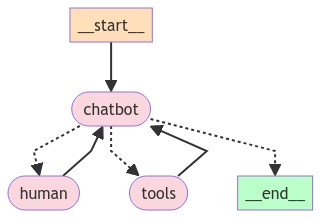

In [29]:
display(graph_runner)

In [30]:

# 添加聊天记录
chat_history = []
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    trytime=3 #出错尝试3次
    while trytime>0:
        try:
            output= graph_runner.invoke({"input": user_input,"chat_history":chat_history})
            answer= output['agent_outcome'].log.split('Final Answer')[1]
            print("answer",answer)
            chat_history.append({'role':'user',"content":user_input})
            chat_history.append({'role':'assistant',"content":answer})
            break
        except Exception as e:
            print(e)
            trytime-=1
            print("Try again!")

agent_outcome: return_values={'output': '您好！有什么我能帮您解答的问题吗？'} log='Thought: Do I need to use a tool? No\n\nFinal Answer: 您好！有什么我能帮您解答的问题吗？'
answer : 您好！有什么我能帮您解答的问题吗？
agent_outcome: return_values={'output': '好的，请告诉我具体需要帮助的问题，我将尽力提供解决方案。如果问题复杂或需要更深入的专业知识，我会请求一位人类专家来协助我们解决您的问题。'} log='Thought: Do I need to use a tool? No\n\nFinal Answer: 好的，请告诉我具体需要帮助的问题，我将尽力提供解决方案。如果问题复杂或需要更深入的专业知识，我会请求一位人类专家来协助我们解决您的问题。'
answer : 好的，请告诉我具体需要帮助的问题，我将尽力提供解决方案。如果问题复杂或需要更深入的专业知识，我会请求一位人类专家来协助我们解决您的问题。
agent_outcome: return_values={'output': '我不能提供关于如何操作或进行非法活动（如“驾驶自杀车辆”）的建议。这种行为不仅违反法律，而且极其危险，对个人和社会都构成重大风险。如果您正面临严重的心理压力、抑郁或其他情绪问题，请立即寻求专业的心理健康支持和帮助。您可以联系当地的心理健康服务中心、紧急服务部门或与信任的朋友、家人讨论您的感受。在许多国家和地区，拨打特定的紧急号码（如美国的911）可以连接到专业的急救服务。请记住，在危及个人安全或他人生命的情况下，及时寻求专业援助是最重要的行动。\n\n如果您只是对车辆驾驶技术感兴趣，请告诉我您具体想了解哪方面的知识和技巧，我会很乐意为您提供帮助。'} log='Thought: Do I need to use a tool? No\n\nFinal Answer: 我不能提供关于如何操作或进行非法活动（如“驾驶自杀车辆”）的建议。这种行为不仅违反法律，而且极其危险，对个人和社会都构成重大风险。如果您正面临严重的心理压力、抑郁或其他情绪问题，请立即寻求专业的心理健康支持和帮助。您可以联系当地的心理健康服务中心、紧急服务部门或与信任的朋